In [1]:
# Instalar dependencias (ejecutar solo una vez)
%pip install seaborn matplotlib -q

Note: you may need to restart the kernel to use updated packages.


# Análisis de Sets de Calibración

Este notebook procesa múltiples runs de calibración agrupados por CalibSetNumber y calcula las constantes de calibración promediadas.

## Proceso:
1. Agrupar runs por set
2. Calcular constantes de calibración (promedio ponderado de offsets)
3. Visualizar matrices de constantes y errores
4. Guardar resultados en Excel

## 1. Configuración e importación

In [2]:
import sys
from pathlib import Path

# Configurar path al proyecto
project_root = Path('..').resolve().parent # Ajusta según la estructura del proyecto
sys.path.insert(0, str(project_root)) # Agrega el directorio raíz del proyecto al path

from RTD_Calibration.src.set import Set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Librería para visualización avanzada

print(f'Directorio del proyecto: {project_root}')
print('Módulos importados correctamente')

Directorio del proyecto: /Users/vicky/Desktop/rtd-calib-simple
Módulos importados correctamente


## 2. Agrupar runs por set

In [3]:
# Inicializar Set
calib_set = Set()

# Especificar sets a procesar (None para procesar todos los números enteros disponibles)
selected_sets = [3, 21]

# Agrupar runs por CalibSetNumber
calib_set.group_runs(selected_sets=selected_sets)

print(f"\nSets procesados: {len(calib_set.runs_by_set)}")
for set_num, runs in calib_set.runs_by_set.items():
    print(f"  Set {int(set_num)}: {len(runs)} runs")

CSV file loaded successfully from '/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/LogFile.csv'.

=== Agrupando runs por CalibSetNumber ===
Sets a procesar: [np.float64(3.0), np.float64(21.0)]

Procesando Set 3.0
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_3/20220531_ln2_r48176_r48177_48060_48479_7.txt
  Datos cargados: 821 registros
  Sensores asociados: 14
  Incluido: 20220531_ln2_r48176_r48177_48060_48479_7
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_3/20220531_ln2_r48176_r48177_48060_48479_8.txt
  Datos cargados: 2260 registros
  Sensores asociados: 14
  Incluido: 20220531_ln2_r48176_r48177_48060_48479_8
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_3/20220531_ln2_r48176_r48177_48060_48479_9.txt
  Datos cargados: 794 registros
  Sensores asociados: 14
  Incluido: 20220531_ln2_r48176_r48177_

## 3. Calcular constantes de calibración

Las constantes se calculan como promedio ponderado de los offsets de todos los runs del set.
El peso de cada run es el inverso del error al cuadrado.

In [4]:
# Calcular constantes de calibración
calib_set.calculate_calibration_constants(selected_sets=selected_sets)

# Mostrar resumen estadístico
summary = calib_set.get_summary()
print("\nResumen de calibración:")
print(summary.to_string(index=False))


=== Calculando matrices de offsets (provisionales) ===

Set 3:
  ✓ 20220531_ln2_r48176_r48177_48060_48479_7
  ✓ 20220531_ln2_r48176_r48177_48060_48479_8
  ✓ 20220531_ln2_r48176_r48177_48060_48479_9
  ✓ 20220531_ln2_r48176_r48177_48060_48479_10
  Sensores excluidos: ['48205', '48478', '48176', '48177']
    - Referencias: ['48176', '48177']
    - Descartados: ['48205', '48478']
  Constantes calculadas: (14, 14)
  Promedio de offsets: 3.4506e-02 K
  Error promedio: 7.1519e-04 K

Set 21:
  ✓ 20250122_ln2_r49263_r49264_49191-49202_1
  ✓ 20250122_ln2_r49263_r49264_49191-49202_2
  ✓ 20250122_ln2_r49263_r49264_49191-49202_3
  ✓ 20250122_ln2_r49263_r49264_49191-49202_4
  Sensores excluidos: ['49191', '49200', '49263', '49264']
    - Referencias: ['49263', '49264']
    - Descartados: ['49191', '49200']
  Constantes calculadas: (14, 14)
  Promedio de offsets: 2.0628e-02 K
  Error promedio: 6.6969e-04 K

Total sets con constantes: 2

Resumen de calibración:
 CalibSetNumber  N_Sensors_Total  N_Sen

### Información de sensores excluidos

Sensores de referencia y descartados que se excluyen del cálculo de constantes.

In [5]:
# Ver sensores excluidos (acceso directo al config)
for set_num in selected_sets:
    set_config = calib_set.config.get('sensors', {}).get('sets', {}).get(set_num, {})
    references = set_config.get('reference', [])
    discarded = set_config.get('discarded', [])
    
    if references or discarded:
        print(f"\nSet {set_num}:")
        if references:
            print(f"  Referencias (excluidas): {references}")
        if discarded:
            print(f"  Descartados (excluidos): {discarded}")


Set 3:
  Referencias (excluidas): [48176, 48177]
  Descartados (excluidos): [48205, 48478]

Set 21:
  Referencias (excluidas): [49263, 49264]
  Descartados (excluidos): [49191, 49200]


## 4. Visualizar matrices de un set específico

Selecciona un set para ver sus matrices de constantes y errores en detalle.

In [6]:
# Seleccionar set a visualizar
set_to_view = 3

if set_to_view in calib_set.calibration_constants:
    constants = calib_set.calibration_constants[set_to_view]
    errors = calib_set.calibration_errors[set_to_view]
    
    print(f"Set {set_to_view}: {constants.shape[0]} sensores")
    print(f"Offset promedio: {np.nanmean(np.abs(constants.values)):.4f} K")
    print(f"Error promedio: {np.nanmean(errors.values):.4f} K")
    
    # Mostrar matriz de constantes (primeros 12x12 sensores)
    print(f"\nConstantes de calibración (primeros 12 sensores):")
    print(constants.iloc[:12, :12].round(5)) # Mostrar solo los primeros 12 sensores y 12 columnas
    
    print(f"\nErrores (primeros 12 sensores):")
    print(errors.iloc[:12, :12].round(5)) #round to 5 decimals
else:
    print(f"Set {set_to_view} no encontrado")

Set 3: 14 sensores
Offset promedio: 0.0345 K
Error promedio: 0.0007 K

Constantes de calibración (primeros 12 sensores):
         48060    48061    48062    48063    48202    48203    48204  48205  \
48060  0.00000  0.03358  0.02337  0.03403  0.10069  0.07362  0.04161    NaN   
48061 -0.03358  0.00000 -0.01027  0.00042  0.06708  0.03997  0.00794    NaN   
48062 -0.02337  0.01027  0.00000  0.01070  0.07764  0.05025  0.01830    NaN   
48063 -0.03403 -0.00042 -0.01070  0.00000  0.06699  0.03953  0.00745    NaN   
48202 -0.10069 -0.06708 -0.07764 -0.06699  0.00000 -0.02727 -0.05919    NaN   
48203 -0.07362 -0.03997 -0.05025 -0.03953  0.02727  0.00000 -0.03205    NaN   
48204 -0.04161 -0.00794 -0.01830 -0.00745  0.05919  0.03205  0.00000    NaN   
48205      NaN      NaN      NaN      NaN      NaN      NaN      NaN    NaN   
48476 -0.08402 -0.05038 -0.06077 -0.04993  0.01667 -0.01040 -0.04245    NaN   
48477 -0.08342 -0.04988 -0.06030 -0.04960  0.01720 -0.00996 -0.04196    NaN   
48478     

### Offsets respecto a sensores raised

Filtra las constantes para mostrar solo los offsets de cada sensor respecto a los sensores 'raised' del set.
Estos valores son los que usa Tree para el encadenamiento entre rondas.

In [7]:
if set_to_view in calib_set.calibration_constants:
    constants = calib_set.calibration_constants[set_to_view]
    errors = calib_set.calibration_errors[set_to_view]
    
    # Obtener sensores raised del config
    set_config = calib_set.config.get('sensors', {}).get('sets', {}).get(set_to_view, {})
    raised_sensors = set_config.get('raised', [])
    
    if raised_sensors:
        # Convertir a strings
        raised_str = [str(s) for s in raised_sensors]
        
        # Filtrar solo columnas de sensores raised
        raised_available = [s for s in raised_str if s in constants.columns]
        
        if raised_available:
            print(f"\nOffsets respecto a sensores raised {raised_sensors}:")
            print(f"(Estos valores son usados por Tree para encadenamiento)\n")
            
            # Mostrar constantes solo hacia sensores raised
            constants_to_raised = constants[raised_available]
            errors_to_raised = errors[raised_available]
            
            print("Constantes (offset en K):")
            print(constants_to_raised.round(5))
            
            print("\nErrores (RMS en K):")
            print(errors_to_raised.round(5))
            
            # Estadísticas
            print("\nEstadísticas de offsets respecto a raised:")
            for raised_sensor in raised_available:
                offsets_col = constants_to_raised[raised_sensor]
                errors_col = errors_to_raised[raised_sensor]
                valid_offsets = offsets_col.dropna()
                
                if len(valid_offsets) > 0:
                    print(f"\n  Sensor raised {raised_sensor}:")
                    print(f"    Sensores conectados: {len(valid_offsets)}")
                    print(f"    Offset medio: {valid_offsets.mean():.5f} K")
                    print(f"    Error medio: {errors_col.dropna().mean():.5f} K")
        else:
            print(f"\nSensores raised {raised_sensors} no encontrados en la matriz")
    else:
        print(f"\nSet {set_to_view} no tiene sensores raised configurados")
else:
    print(f"Set {set_to_view} no encontrado")


Offsets respecto a sensores raised [48203, 48479]:
(Estos valores son usados por Tree para encadenamiento)

Constantes (offset en K):
         48203    48479
48060  0.07362  0.06636
48061  0.03997  0.03284
48062  0.05025  0.04309
48063  0.03953  0.03238
48202 -0.02727 -0.03443
48203  0.00000 -0.00720
48204  0.03205  0.02481
48205      NaN      NaN
48476 -0.01040 -0.01771
48477 -0.00996 -0.01710
48478      NaN      NaN
48479  0.00720  0.00000
48176      NaN      NaN
48177      NaN      NaN

Errores (RMS en K):
         48203    48479
48060  0.00062  0.00046
48061  0.00036  0.00056
48062  0.00062  0.00056
48063  0.00077  0.00055
48202  0.00096  0.00114
48203  0.00000  0.00034
48204  0.00062  0.00086
48205      NaN      NaN
48476  0.00079  0.00105
48477  0.00063  0.00087
48478      NaN      NaN
48479  0.00034  0.00000
48176      NaN      NaN
48177      NaN      NaN

Estadísticas de offsets respecto a raised:

  Sensor raised 48203:
    Sensores conectados: 10
    Offset medio: 0.01950 K


### Visualización gráfica de las matrices

Heatmaps de constantes y errores para el set seleccionado.

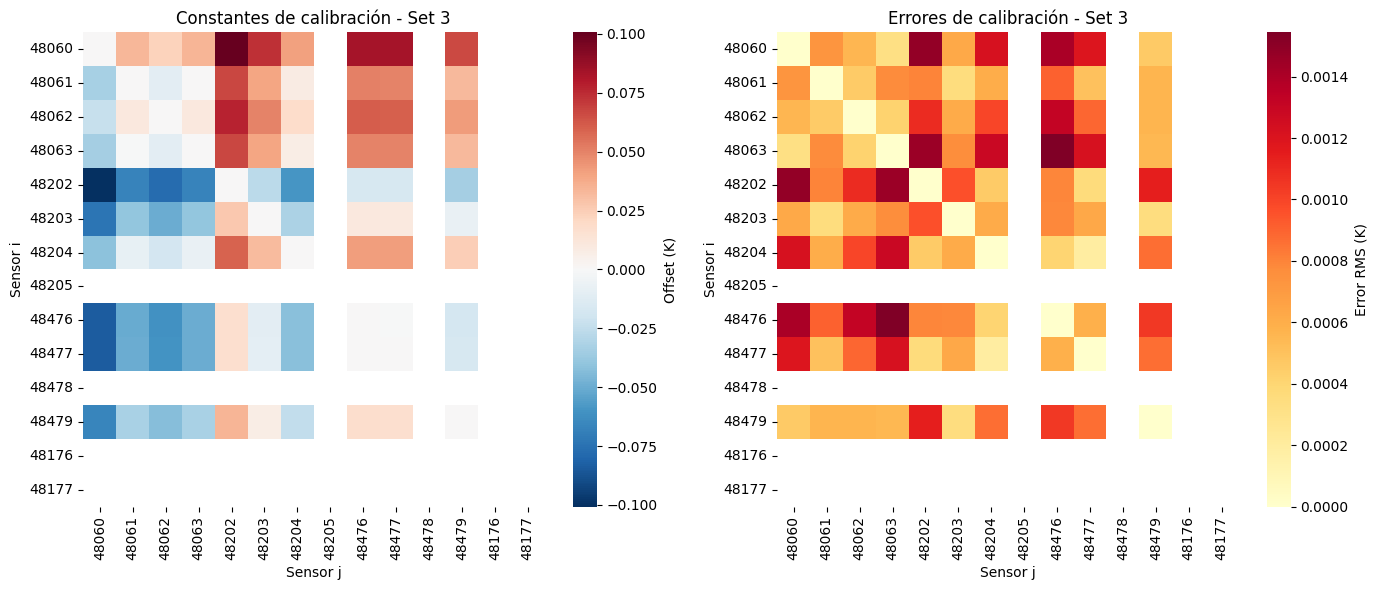


Estadísticas de offsets (valores absolutos):
  Mínimo: 0.0000 K
  Máximo: 0.1007 K
  Media: 0.0345 K
  Mediana: 0.0332 K


In [11]:
if set_to_view in calib_set.calibration_constants:
    constants = calib_set.calibration_constants[set_to_view]
    errors = calib_set.calibration_errors[set_to_view]
    
    # Crear figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Heatmap de constantes
    sns.heatmap(constants, annot=False, fmt='.3f', cmap='RdBu_r', 
                center=0, cbar_kws={'label': 'Offset (K)'}, ax=axes[0])
    axes[0].set_title(f'Constantes de calibración - Set {set_to_view}')
    axes[0].set_xlabel('Sensor j')
    axes[0].set_ylabel('Sensor i')
    
    # Heatmap de errores
    sns.heatmap(errors, annot=False, fmt='.4f', cmap='YlOrRd', 
                cbar_kws={'label': 'Error RMS (K)'}, ax=axes[1])
    axes[1].set_title(f'Errores de calibración - Set {set_to_view}')
    axes[1].set_xlabel('Sensor j')
    axes[1].set_ylabel('Sensor i')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de la matriz
    print("\nEstadísticas de offsets (valores absolutos):")
    print(f"  Mínimo: {np.nanmin(np.abs(constants.values)):.4f} K")
    print(f"  Máximo: {np.nanmax(np.abs(constants.values)):.4f} K")
    print(f"  Media: {np.nanmean(np.abs(constants.values)):.4f} K")
    print(f"  Mediana: {np.nanmedian(np.abs(constants.values)):.4f} K")

### Comparar offsets entre sensores específicos

Visualiza los offsets de un sensor respecto a todos los demás.

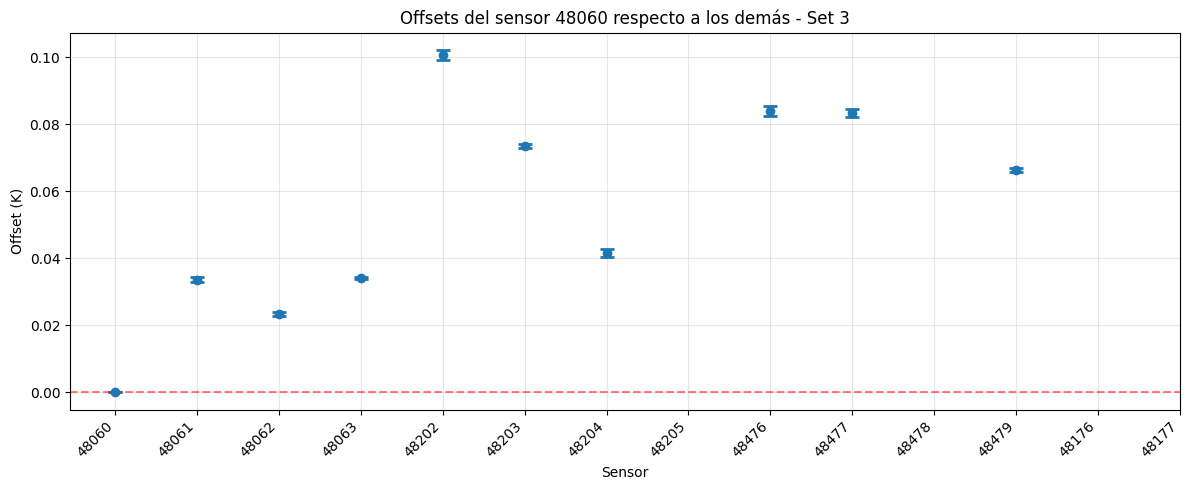

In [9]:
if set_to_view in calib_set.calibration_constants:
    constants = calib_set.calibration_constants[set_to_view]
    errors = calib_set.calibration_errors[set_to_view]
    
    # Seleccionar un sensor de referencia
    reference_sensor = constants.index[0]
    
    # Extraer offsets del sensor de referencia respecto a los demás
    offsets_vs_ref = constants.loc[reference_sensor, :]
    errors_vs_ref = errors.loc[reference_sensor, :]
    
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(12, 5))
    x_pos = np.arange(len(offsets_vs_ref))
    
    ax.errorbar(x_pos, offsets_vs_ref, yerr=errors_vs_ref, 
                fmt='o', capsize=5, capthick=2, markersize=6)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(offsets_vs_ref.index, rotation=45, ha='right')
    ax.set_xlabel('Sensor')
    ax.set_ylabel('Offset (K)')
    ax.set_title(f'Offsets del sensor {reference_sensor} respecto a los demás - Set {set_to_view}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Guardar resultados

Exporta las matrices de constantes y errores a un archivo Excel.

In [10]:
# Guardar resultados en Excel y CSV
calib_set.save_results(output_file="set_calibration_results.xlsx", save_csv=True)

print(f"\nArchivos generados para {len(calib_set.calibration_constants)} sets:")
print("  - Excel: set_calibration_results.xlsx (todas las hojas)")
print("  - CSV: set_N_constants.csv y set_N_errors.csv (por cada set)")
print("\nLos sensores excluidos (referencias y descartados) aparecen como NaN en los CSV")


Guardando resultados...
✓ Excel guardado en /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/docs/set_calibration_results.xlsx
✓ CSVs guardados en /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/docs/ (set_N_constants.csv, set_N_errors.csv)

Archivos generados para 2 sets:
  - Excel: set_calibration_results.xlsx (todas las hojas)
  - CSV: set_N_constants.csv y set_N_errors.csv (por cada set)

Los sensores excluidos (referencias y descartados) aparecen como NaN en los CSV
